## Introduction

This notebook explores and begins to model wildfire data in an attempt to create a model that can predict the size of a fire based on various points of weather data and location.

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas as gpd
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

#### Styling

In [2]:
mpl.rcParams['axes.facecolor'] = '#003049'
color1 = '#F77F00'
color2 = '#888DA7'

#### Importing Data

In [3]:
#MTBS Wildfire and Region Data
mtbs = pd.read_csv('MTBS_and_Region.csv')

In [4]:
#Climate data
level_1_weather = pd.read_csv('Ecoregion Level 1 Weather.csv', skiprows=[1])

## MTBS Data Cleaning

In [5]:
mtbs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23372 entries, 0 to 23371
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  23372 non-null  int64  
 1   Fire_ID     23372 non-null  object 
 2   Fire_Name   23372 non-null  object 
 3   Asmnt_Type  23372 non-null  object 
 4   Pre_ID      15909 non-null  object 
 5   Post_ID     23372 non-null  object 
 6   Fire_Type   23372 non-null  object 
 7   ND_T        23372 non-null  float64
 8   IG_T        23372 non-null  float64
 9   Low_T       23372 non-null  float64
 10  Mod_T       23372 non-null  float64
 11  High_T      23372 non-null  float64
 12  IG_Date     23372 non-null  object 
 13  Lat         23372 non-null  float64
 14  Long        23372 non-null  float64
 15  Acres       23372 non-null  float64
 16  NA_L3NAME   22160 non-null  object 
 17  NA_L2NAME   22160 non-null  object 
 18  NA_L1NAME   22160 non-null  object 
dtypes: float64(8), int64(1), 

From what I can gather, these are the descriptions for the columns in our dataset:
1. **Unnamed: 0** - Seems to be a counter column
2. **Fire_ID** - Fire ID, includes state of origin in the first two letters
3. **Fire_Name** - Fire name
4. **Asmnt_Type** - Unsure
5. **Pre_ID** - ID before contained
6. **Post_ID** - ID after contained
7. **Fire_Type** - Type of fire
8. **ND_T** - Unsure
9. **IG_T** - Unsure
10. **Low_T** - Lowest temperature
11. **Mod_T** - Mode temperature
12. **High_T** - Highest temperature
13. **Lat** - Latitude of origin
14. **Long** - Longitude of origin
15. **Acres** - Acres burned
16. **NA_L3NAME** - most detailed, level 3 ecoregions, nested within level 2 ecoregions
17. **NA_L2NAME** - more detailed, level 2 ecoregions, nested within level 1 ecoregions
18. **NA_L1NAME** - broad, level 1 ecoregions

In [6]:
mtbs.head()

,Unnamed: 0,Fire_ID,Fire_Name,Asmnt_Type,Pre_ID,Post_ID,Fire_Type,ND_T,IG_T,Low_T,Mod_T,High_T,IG_Date,Lat,Long,Acres,NA_L3NAME,NA_L2NAME,NA_L1NAME
0,0,OK3677609586220120329,UNNAMED,Initial (SS),NaN,702703420120329,Unknown,0.0,0.0,60.0,-9999.0,-9999.0,2012-03-29,36.773,-95.864,1175.0,Central Irregular Plains,TEMPERATE PRAIRIES,GREAT PLAINS
1,1,CA3893112229619980829,MIDDLE,Extended,504403319961026,504403319991104,Wildfire,-970.0,-150.0,80.0,216.0,400.0,1998-08-29,38.931,-122.296,6385.0,"California Coastal Sage, Chaparral, and Oak Wo...",MEDITERRANEAN CALIFORNIA,MEDITERRANEAN CALIFORNIA
2,2,CA4097912029519980831,MCDONALD,Extended,504303219980721,704303219990630,Prescribed Fire,-970.0,-150.0,25.0,169.0,350.0,1998-08-31,40.979,-120.295,3278.0,Eastern Cascades Slopes and Foothills,WESTERN CORDILLERA,NORTHWESTERN FORESTED MOUNTAINS
3,3,CO4066310869519980209,CONWAY,Initial,503603220081019,503603219981008,Prescribed Fire,-970.0,-150.0,100.0,213.0,380.0,1998-02-09,40.663,-108.695,1462.0,Wyoming Basin,COLD DESERTS,NORTH AMERICAN DESERTS
4,4,CO4042010872219980101,3 SPRINGS,Initial,503603219971021,503603219981024,Prescribed Fire,-970.0,-150.0,20.0,159.0,335.0,1998-01-01,40.420,-108.722,1468.0,Colorado Plateaus,COLD DESERTS,NORTH AMERICAN DESERTS


#### Removing Excess Columns

In [7]:
col_rmv = ['Unnamed: 0', 'Fire_Name', 'Pre_ID', 'Post_ID',]
mtbs.drop(columns=col_rmv, inplace=True)

#### Adding New Columns

In [8]:
#Generating a state column from the first two letters of the fire ID
mtbs['state'] = pd.Series([s[0:2] for s in mtbs['Fire_ID']])

In [9]:
#Creating a month, day, and year column from the IG_Date
mtbs['year_ig'] = pd.Series([s[0:4] for s in mtbs['IG_Date']])
mtbs['month_ig'] = pd.Series([s[5:7] for s in mtbs['IG_Date']])
mtbs['day_ig'] = pd.Series([s[8:10] for s in mtbs['IG_Date']])

mtbs['IG_Date'] = pd.to_datetime(mtbs['IG_Date'], format='%Y-%m-%d')

#### Checking for missing values

Value Counts for IG_T
-150.0     15442
-9999.0     5459
 0.0        1705
 9999.0      282
-250.0       117
Name: IG_T, dtype: int64


Histogram for IG_T


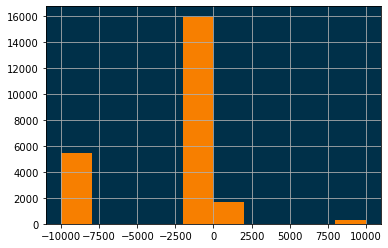

In [10]:
#code for checking variables and values
var = 'IG_T'
print("Value Counts for {}".format(var))
print(mtbs[var].value_counts().head())
print("\n")
print("Histogram for {}".format(var))
mtbs[var].hist(color=color1)
plt.show()

It looks like `-9999` and `9999` are used as indicators for missing values. I will go through, replacing all the instances of `-9999`/`9999` with `NaN`.

In [11]:
#Replacing -9999 and 9999 with NaN
missing_cols = ['ND_T', 'IG_T', 'Low_T', 'Mod_T', 'High_T']

for col in missing_cols:
    mtbs[col] = np.where((mtbs[col] == -9999), np.nan, mtbs[col])
    mtbs[col] = np.where((mtbs[col] == 9999), np.nan, mtbs[col])
    mtbs[col] = np.where((mtbs[col] == 99999), np.nan, mtbs[col])

In [12]:
#Now replacing NaN with column median
for col in missing_cols:
    mtbs[col] = mtbs[col].fillna(mtbs[col].median())

In [13]:
#Checking the rows with missing values for eco regions
mtbs.loc[mtbs['NA_L3NAME'].isnull()].head()

,Fire_ID,Asmnt_Type,Fire_Type,ND_T,IG_T,Low_T,Mod_T,High_T,IG_Date,Lat,Long,Acres,NA_L3NAME,NA_L2NAME,NA_L1NAME,state,year_ig,month_ig,day_ig
896,AK6175916306020160715,Extended,Wildfire,-970.0,-150.0,70.0,330.0,500.0,2016-07-15,61.748,-163.070,1151.0,NaN,NaN,NaN,AK,2016,07,15
897,AK6105016359820160602,Extended,Wildfire,-970.0,-150.0,60.0,325.0,500.0,2016-06-02,61.028,-163.575,2266.0,NaN,NaN,NaN,AK,2016,06,02
898,AK6205516117920160603,Extended,Wildfire,-970.0,-150.0,0.0,315.0,605.0,2016-06-03,62.060,-161.247,20099.0,NaN,NaN,NaN,AK,2016,06,03
899,AK6105916133420160714,Extended,Wildfire,-970.0,-150.0,30.0,350.0,500.0,2016-07-14,61.057,-161.331,1380.0,NaN,NaN,NaN,AK,2016,07,14
900,AK6135616082720160714,Extended,Wildfire,-970.0,-150.0,5.0,300.0,500.0,2016-07-14,61.357,-160.786,6179.0,NaN,NaN,NaN,AK,2016,07,14


In [14]:
mtbs.loc[mtbs['NA_L3NAME'].isnull()]['state'].value_counts()

AK    1168
HI      19
PR       7
MN       4
CA       3
NM       3
TX       2
FL       1
AZ       1
MT       1
VA       1
NC       1
WA       1
Name: state, dtype: int64

It looks like most of the fires not assigned to an ecoregion are outside the continental U.S., mainly Alaska. I'll go ahead and remove all the rows that don't have assigned ecoregions.

In [15]:
#Dropping rows without ecoregions
mtbs.dropna(subset=['NA_L3NAME'], inplace=True)

In [16]:
#Value counts for asmnt_type and fire_type
print(mtbs['Fire_Type'].value_counts().head(10))
print('\n')
print(mtbs['Asmnt_Type'].value_counts().head(10))

Wildfire                12730
Prescribed Fire          5651
Unknown                  3638
Wildland Fire Use         135
Complex                     4
Out of Area Response        2
Name: Fire_Type, dtype: int64


Initial          10697
Initial (SS)      7292
Extended          4100
Extended (SS)       71
Name: Asmnt_Type, dtype: int64


As I'm unsure what the `Asmnt_Type` column stands for and the fact that it only has two main values, I'm going to remove it from this analysis. I will also use this as an opportunity to remove the `ND_T` and `IG_T` columns, because I'm unsure of what they represent as well.

In [17]:
#removing final round of columns
additional_col_rmv = ['Asmnt_Type', 'ND_T', 'IG_T']
mtbs.drop(columns=additional_col_rmv, inplace=True)

In [18]:
#renaming date column for merge later on
mtbs.rename(columns={'IG_Date':'Date'}, inplace=True)

## Data Exploration

### MTBS Fire Dataset

In [19]:
#Date range
print('Start of MTBS fire data: {}'.format(mtbs['Date'].min()))
print('End of MTBS fire data: {}'.format(mtbs['Date'].max()))

Start of MTBS fire data: 1984-02-21 00:00:00
End of MTBS fire data: 2018-11-16 00:00:00


In [20]:
#Number of Dates
len(mtbs['Date'].unique())

6694

In [21]:
mtbs.describe()

,Low_T,Mod_T,High_T,Lat,Long,Acres
count,22160.000000,22160.000000,22160.000000,22160.000000,22160.000000,2.216000e+04
mean,143.157310,253.684928,475.853881,36.546650,-100.000672,6.564277e+03
std,172.397013,235.585193,144.208673,5.812422,14.109949,2.388438e+04
min,-230.000000,-538.000000,-690.000000,25.218000,-124.163000,5.000000e+02
25%,50.000000,241.000000,500.000000,31.536750,-113.780750,1.232750e+03
50%,80.000000,275.000000,500.000000,36.380000,-96.835500,2.049000e+03
75%,170.000000,294.000000,500.000000,40.750500,-85.616750,4.437500e+03
max,1100.000000,8888.000000,1041.000000,48.998000,-67.213000,1.183539e+06


#### Column Exploration

In [22]:
#Function for column counts
def col_count(col, xticks=False):
    """Create an sns.countplot for a specific column in the mtbs fires dataset.
    
    Parameters:
    col - column to be plotted
    xticks - If True, rotates the xlabels for longer values. Default, false
    """
    plt.figure(figsize=(18,6))
    sns.countplot(mtbs[col], color=color1)
    plt.xlabel('{}'.format(col))
    plt.ylabel('Number of Fires')
    plt.title('Number of Fires per {}'.format(col))
    if xticks:
        plt.xticks(rotation=45)
    plt.show()

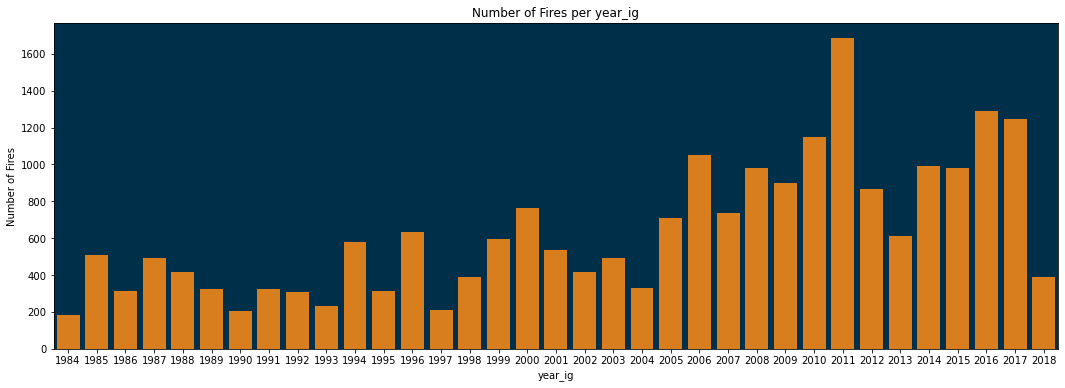

In [23]:
#Number of Fires per year
col_count('year_ig')

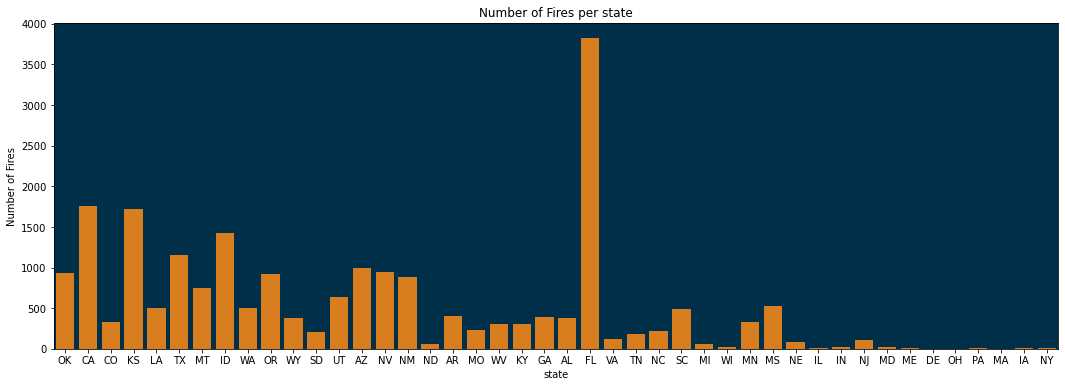

In [24]:
#Number of fires per state
col_count('state')

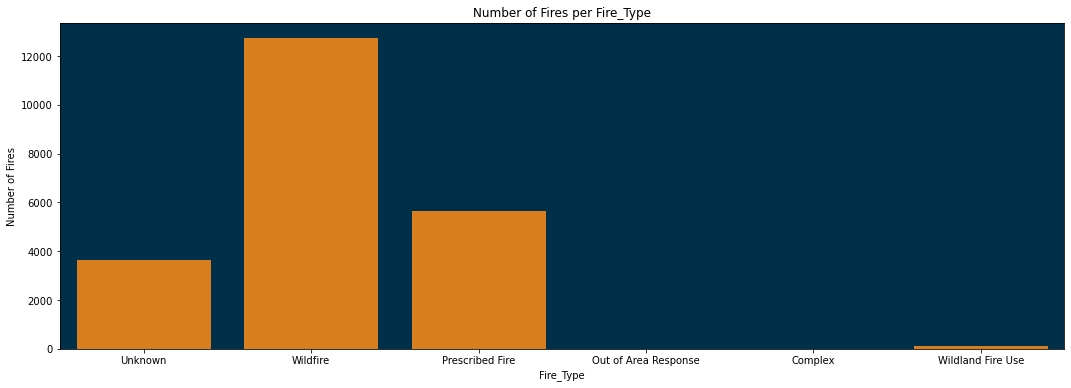

In [25]:
col_count('Fire_Type')

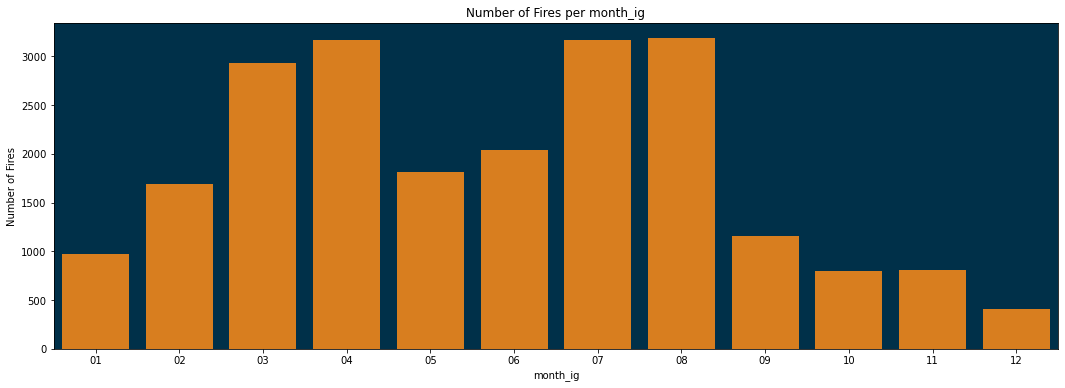

In [26]:
col_count('month_ig')

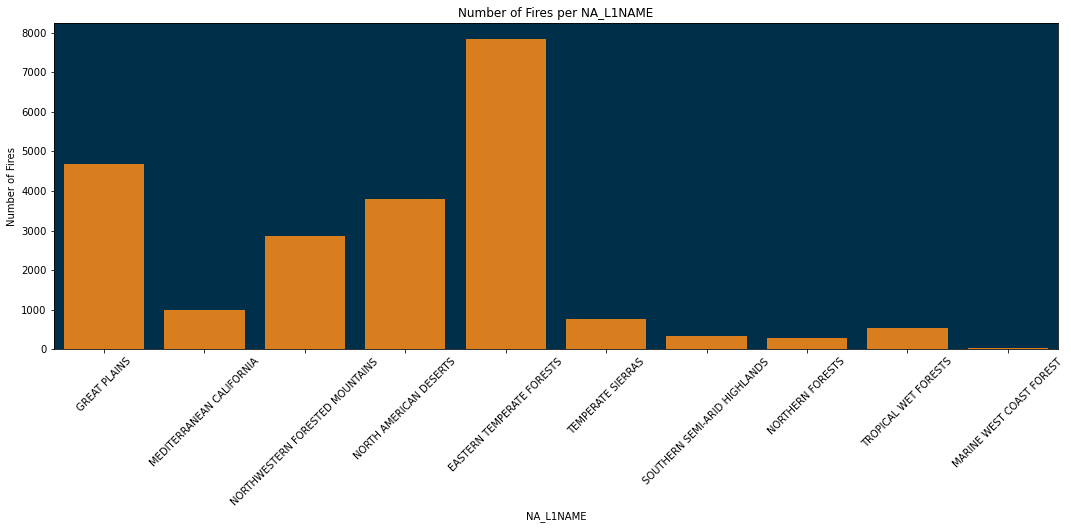

In [27]:
col_count('NA_L1NAME', True)

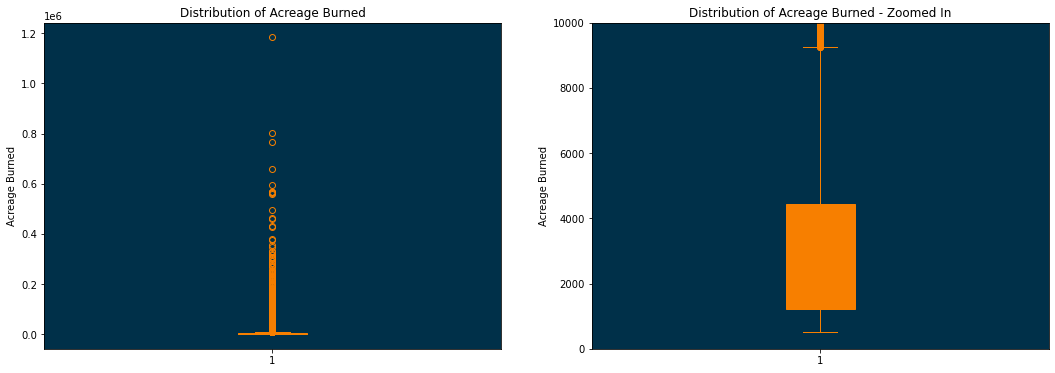

In [28]:
#Visualization of fire size
fig = plt.figure(figsize=(18,6))
coord1 = 121
coord2 = 122

plt.subplot(coord1)
plt.boxplot(mtbs['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
plt.ylabel('Acreage Burned')
plt.title('Distribution of Acreage Burned')

plt.subplot(coord2)
plt.boxplot(mtbs['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
plt.ylabel('Acreage Burned')
plt.ylim(0,10000)
plt.title('Distribution of Acreage Burned - Zoomed In')

fig.show()

##### Column exploration summary

From the above count plots, we can gather the following information:
1. The number of fires seems to be increasing as the years go on.
2. Most of the fires have occured in Florida, which I found strange. I'll need to look at the size breakdown fires in different states, to see if there is a pattern there.
3. A majority of the fires in this dataset are considered wildfires, though there is a significant amount of fires that were prescribed.
4. As is predicted, most of the fires happen in the later months of the summer. What was unexpected was the number of fires that occured in the late spring. These must have occured in southern states. I'll have to look further into this.
5. The top four broad ecoregions where fires occur are the Great Plains, Northwestern Forested Mountains, North American Deserts, and Eastern Temperate Forests. Since they're are too many detailed descriptions of ecoregions, I won't create countplots of those, but I will look into their trends in other ways further on.
6. All fires in this dataset were at least 500 acres in burn area, while the average fire in this dataset appears to have burned around 2,000 acres. I'd like to look further into the breakdown of fire size, fire type, and location.

#### MTBS - Deeper Exploration

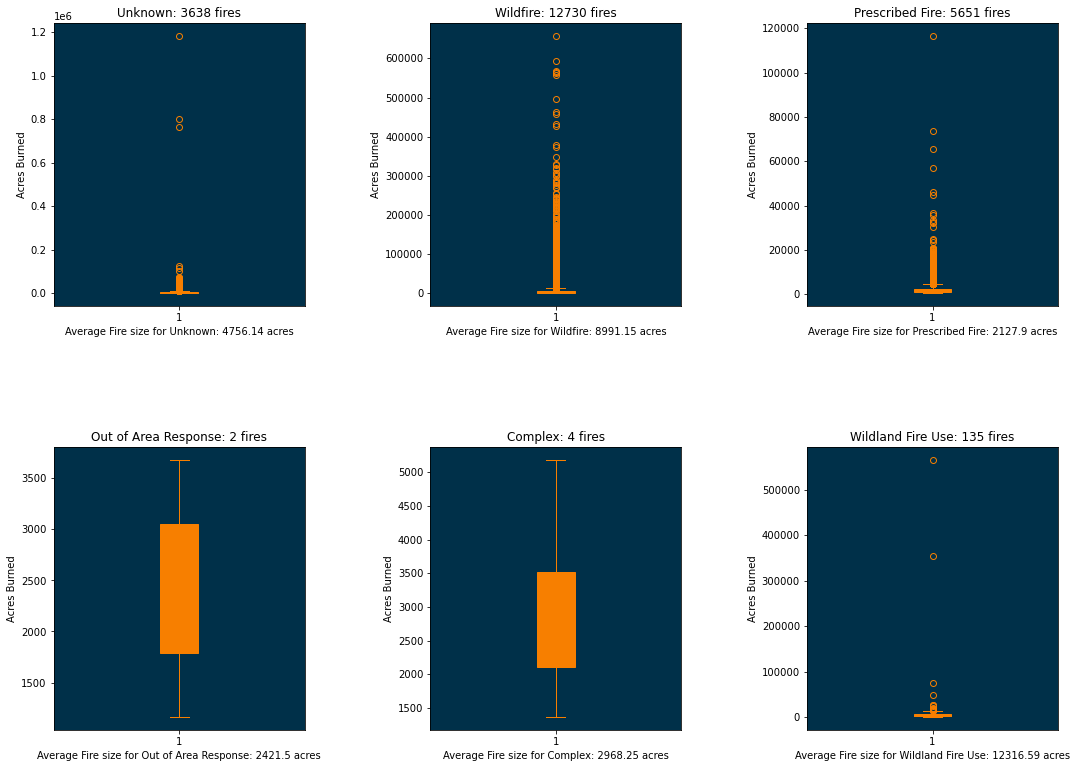

In [29]:
#Visualizing fire type and size
types = mtbs.Fire_Type.unique()
fig, axs = plt.subplots(2,3, figsize=(18, 13))
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()

for i in range(len(types)):
    var = types[i]
    df = mtbs[mtbs['Fire_Type'] == var]
    
    axs[i].boxplot(df['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
    axs[i].set_title("{}: {} fires".format(var, len(df)))
    axs[i].set_ylabel('Acres Burned')
    axs[i].set_xlabel('Average Fire size for {}: {} acres'.format(var, round(df['Acres'].mean(),2)))

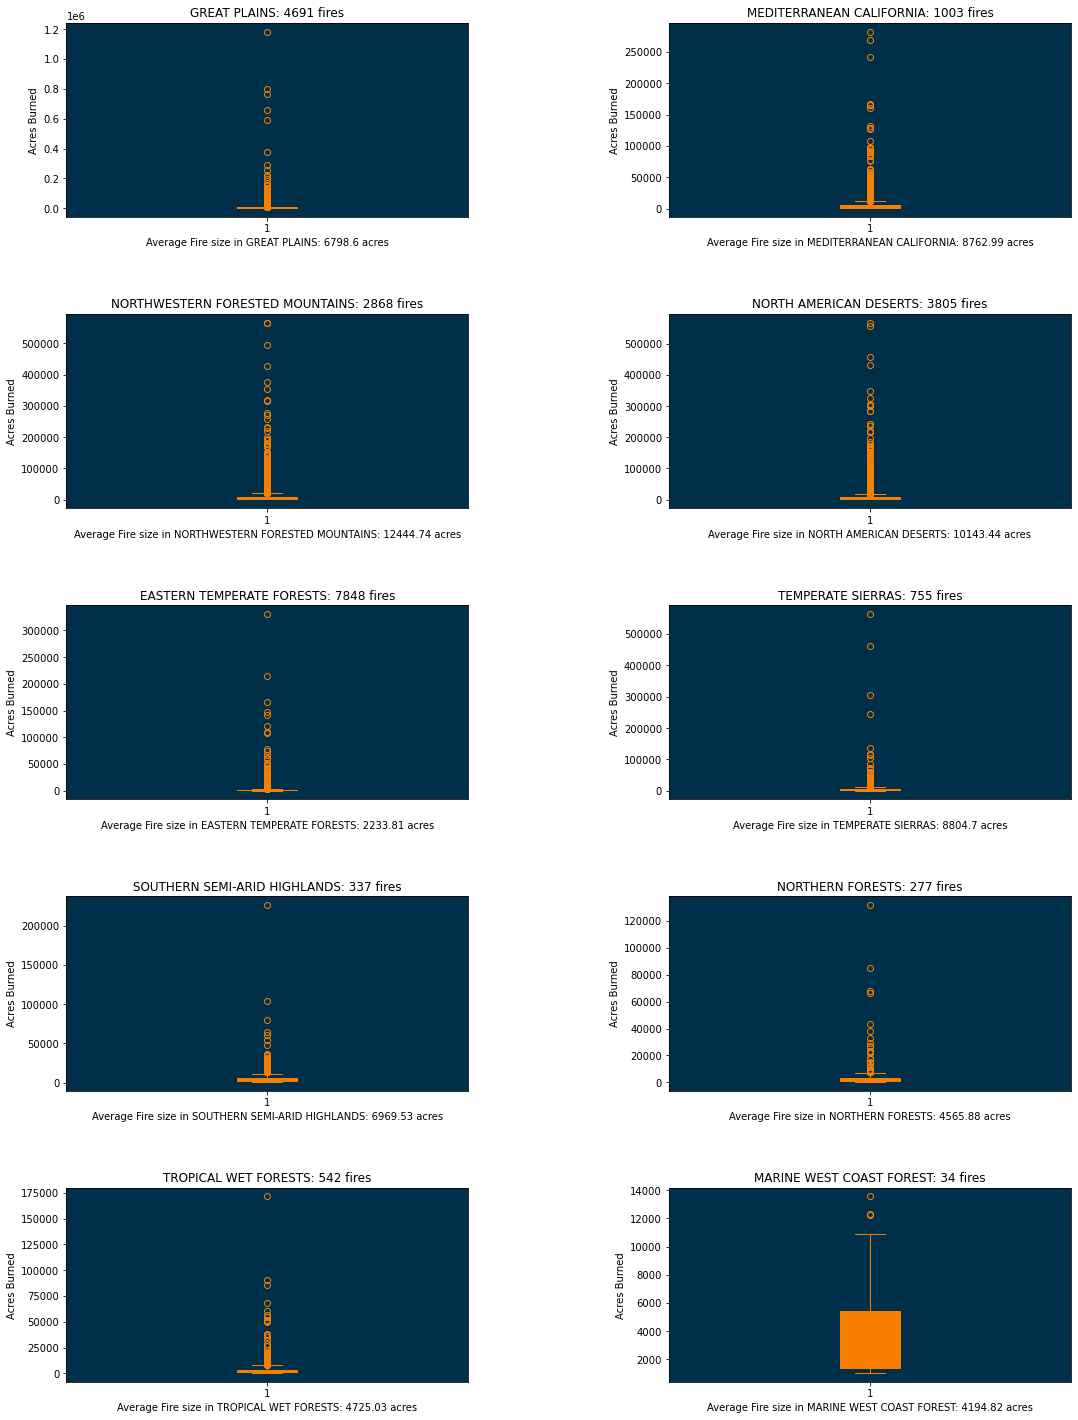

In [30]:
#Visualizing ecoregions and fire size
regions = mtbs.NA_L1NAME.unique()
fig, axs = plt.subplots(5,2, figsize=(18, 25))
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()

for i in range(len(regions)):
    var = regions[i]
    df = mtbs[mtbs['NA_L1NAME'] == var]
    
    axs[i].boxplot(df['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
    axs[i].set_title("{}: {} fires".format(var, len(df)))
    axs[i].set_ylabel('Acres Burned')
    axs[i].set_xlabel('Average Fire size in {}: {} acres'.format(var, round(df['Acres'].mean(),2)))

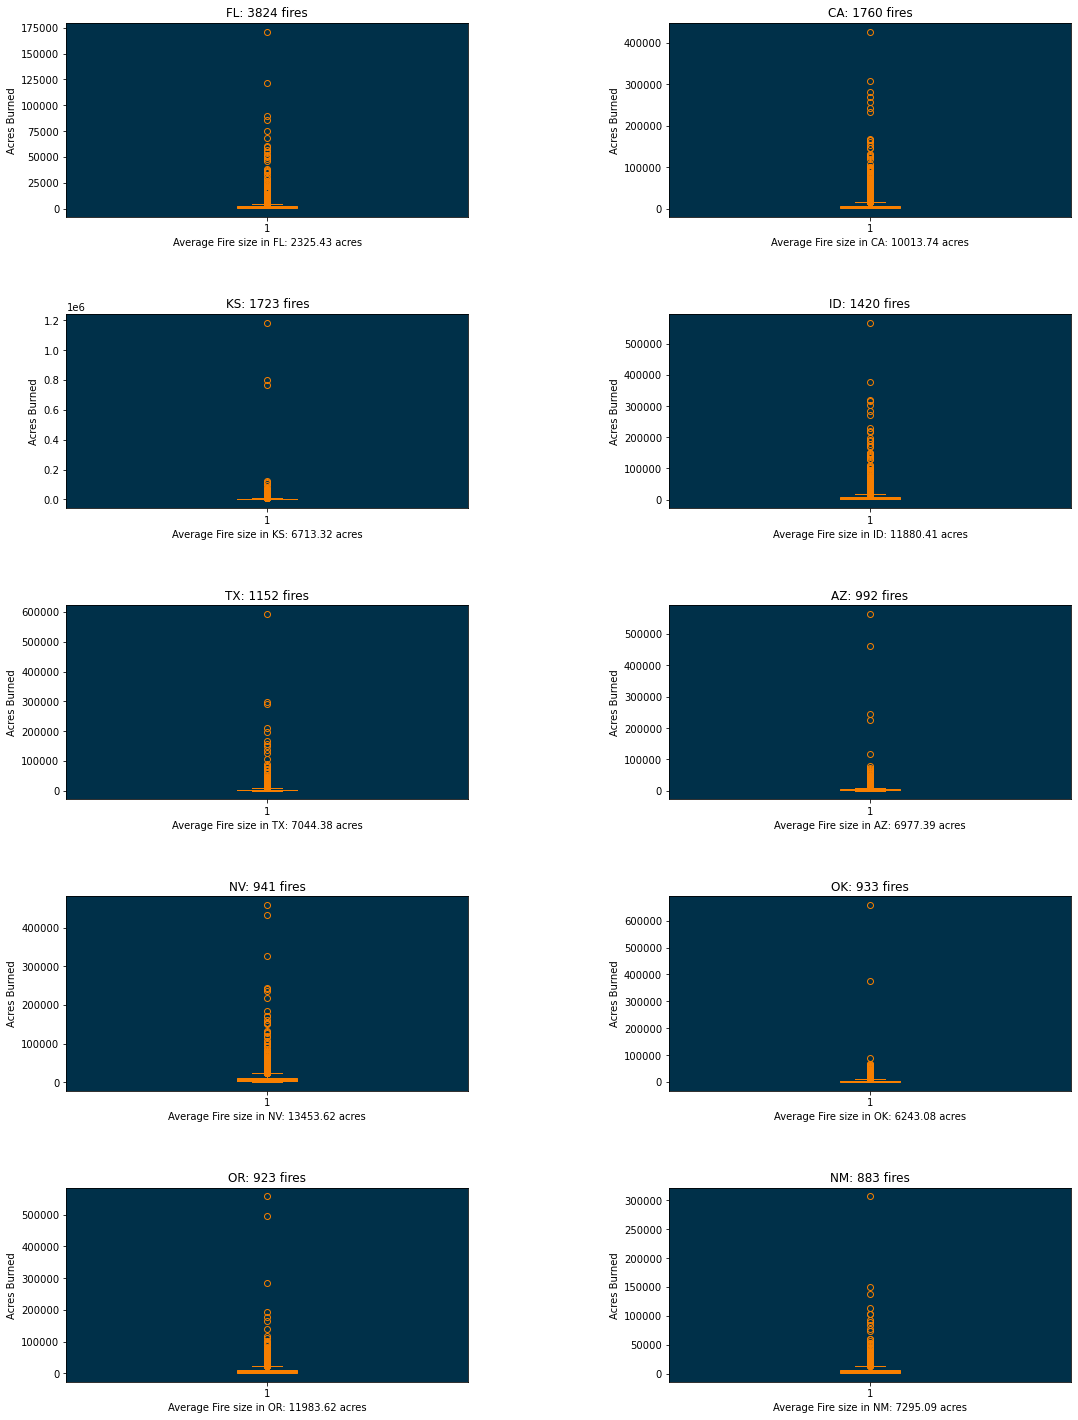

In [31]:
#Visualizing top states and fire size
top_states = list(pd.DataFrame(mtbs['state'].value_counts().head(10)).reset_index()['index'])
fig, axs = plt.subplots(5,2, figsize=(18, 25))
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()

for i in range(len(top_states)):
    var = top_states[i]
    df = mtbs[mtbs['state'] == var]
    
    axs[i].boxplot(df['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
    axs[i].set_title("{}: {} fires".format(var, len(df)))
    axs[i].set_ylabel('Acres Burned')
    axs[i].set_xlabel('Average Fire size in {}: {} acres'.format(var, round(df['Acres'].mean(),2)))

In [32]:
#looking at more detailed eco regions
def eco_10_size(var):
    """This function creates similar boxplots to those scene above, but instead create them for the top 10 level 3
    ecosystems found within the broad, level 1 ecosystem. Returns 10 boxplots.
    
    Variables:
    var - Level 1 ecosystem to inspect"""
    
    fig, axs = plt.subplots(5,2, figsize=(18, 25))
    fig.subplots_adjust(hspace = .5, wspace=.5)

    axs = axs.ravel()
    
    df1 = mtbs[mtbs['NA_L1NAME'] == var]
    ecos = list(pd.DataFrame(df1['NA_L3NAME'].value_counts().head(10)).reset_index()['index'])
    
    print('Level 3 ecosystems within {}'.format(var))
    
    for i in range(len(ecos)):
        var2 = ecos[i]
        df2 = mtbs[mtbs['NA_L3NAME'] == var2]
    
        axs[i].boxplot(df2['Acres'], patch_artist=True,
           boxprops=dict(facecolor=color1, color=color1),
           capprops=dict(color=color1),
            whiskerprops=dict(color=color1),
            flierprops=dict(color=color1, markeredgecolor=color1),
            medianprops=dict(color=color1))
        axs[i].set_title("{}: {} fires".format(var2, len(df2)))
        axs[i].set_ylabel('Acres Burned')
        axs[i].set_xlabel('Average Fire size in {}: {} acres'.format(var2, round(df2['Acres'].mean(),2)))

In [33]:
top_5_ecos = list(pd.DataFrame(mtbs['NA_L1NAME'].value_counts().head(5)).reset_index()['index'])
print(top_5_ecos)

['EASTERN TEMPERATE FORESTS', 'GREAT PLAINS', 'NORTH AMERICAN DESERTS', 'NORTHWESTERN FORESTED MOUNTAINS', 'MEDITERRANEAN CALIFORNIA']


Level 3 ecosystems within EASTERN TEMPERATE FORESTS


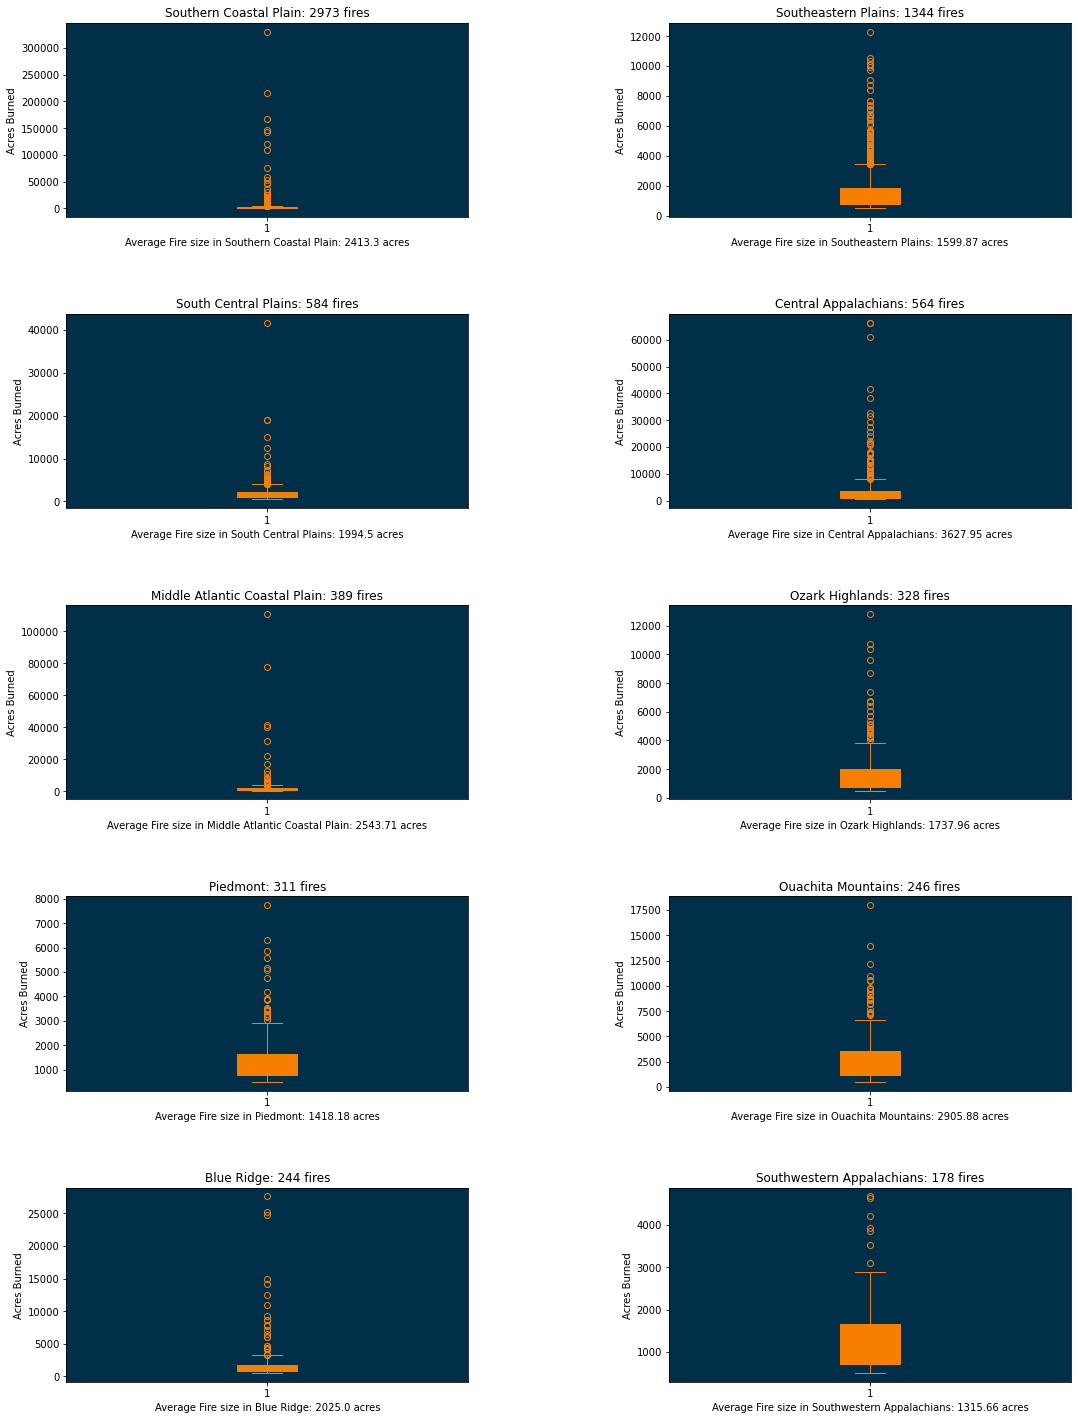

In [34]:
#Eastern Temperate Forests
eco_10_size(top_5_ecos[0])

Level 3 ecosystems within GREAT PLAINS


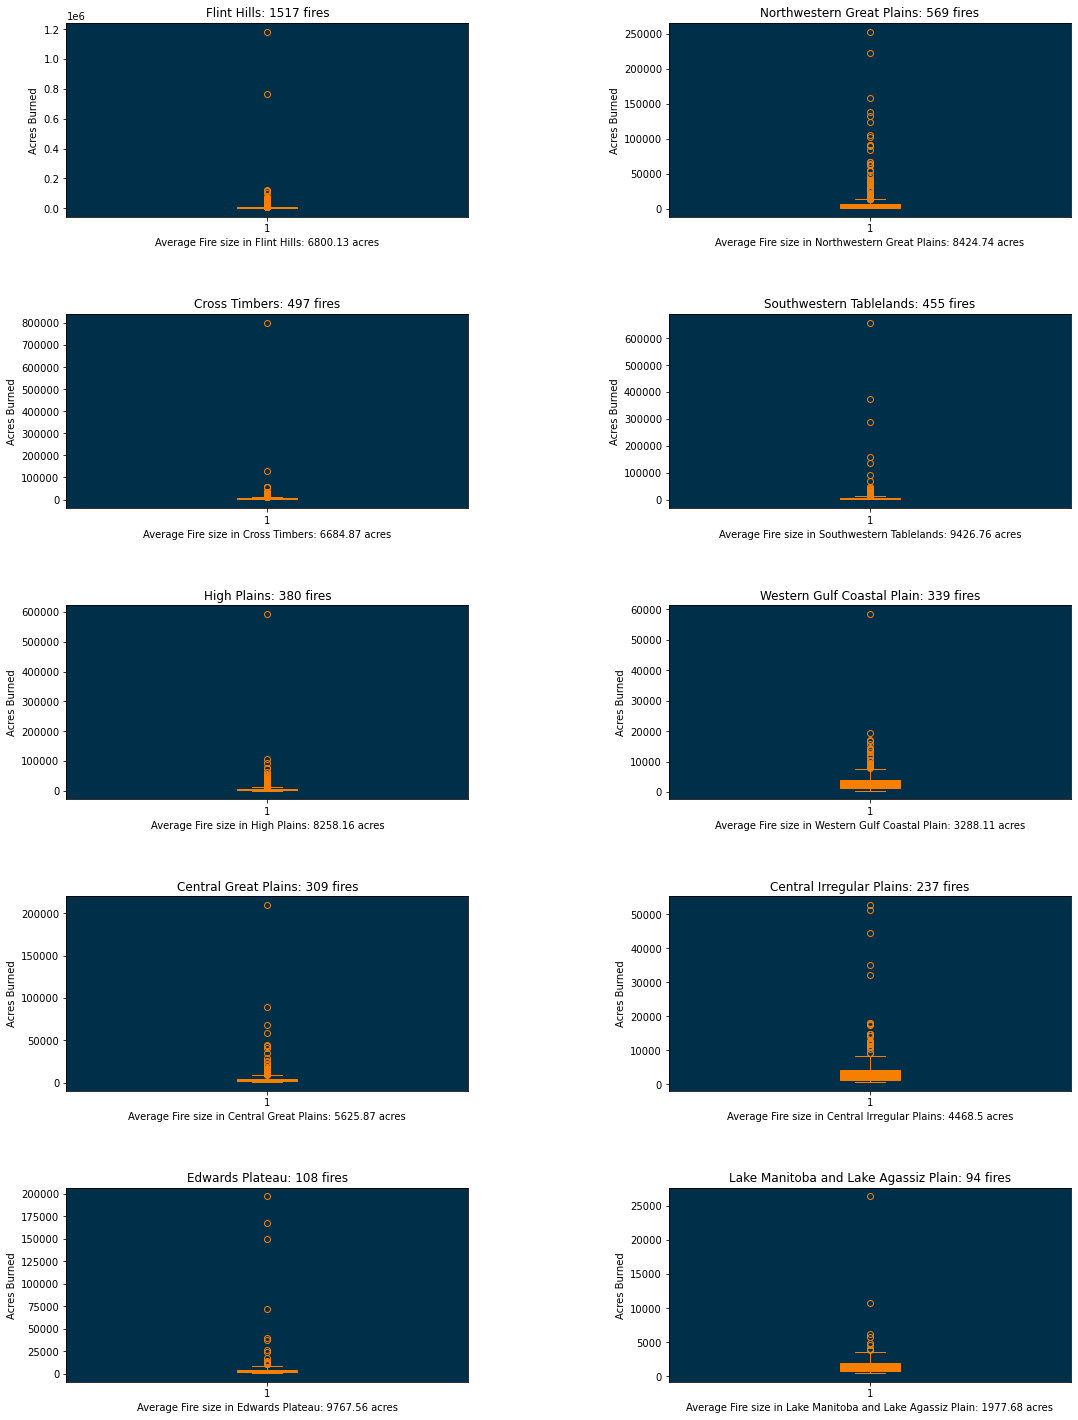

In [35]:
#Great Plains
eco_10_size(top_5_ecos[1])

Level 3 ecosystems within NORTH AMERICAN DESERTS


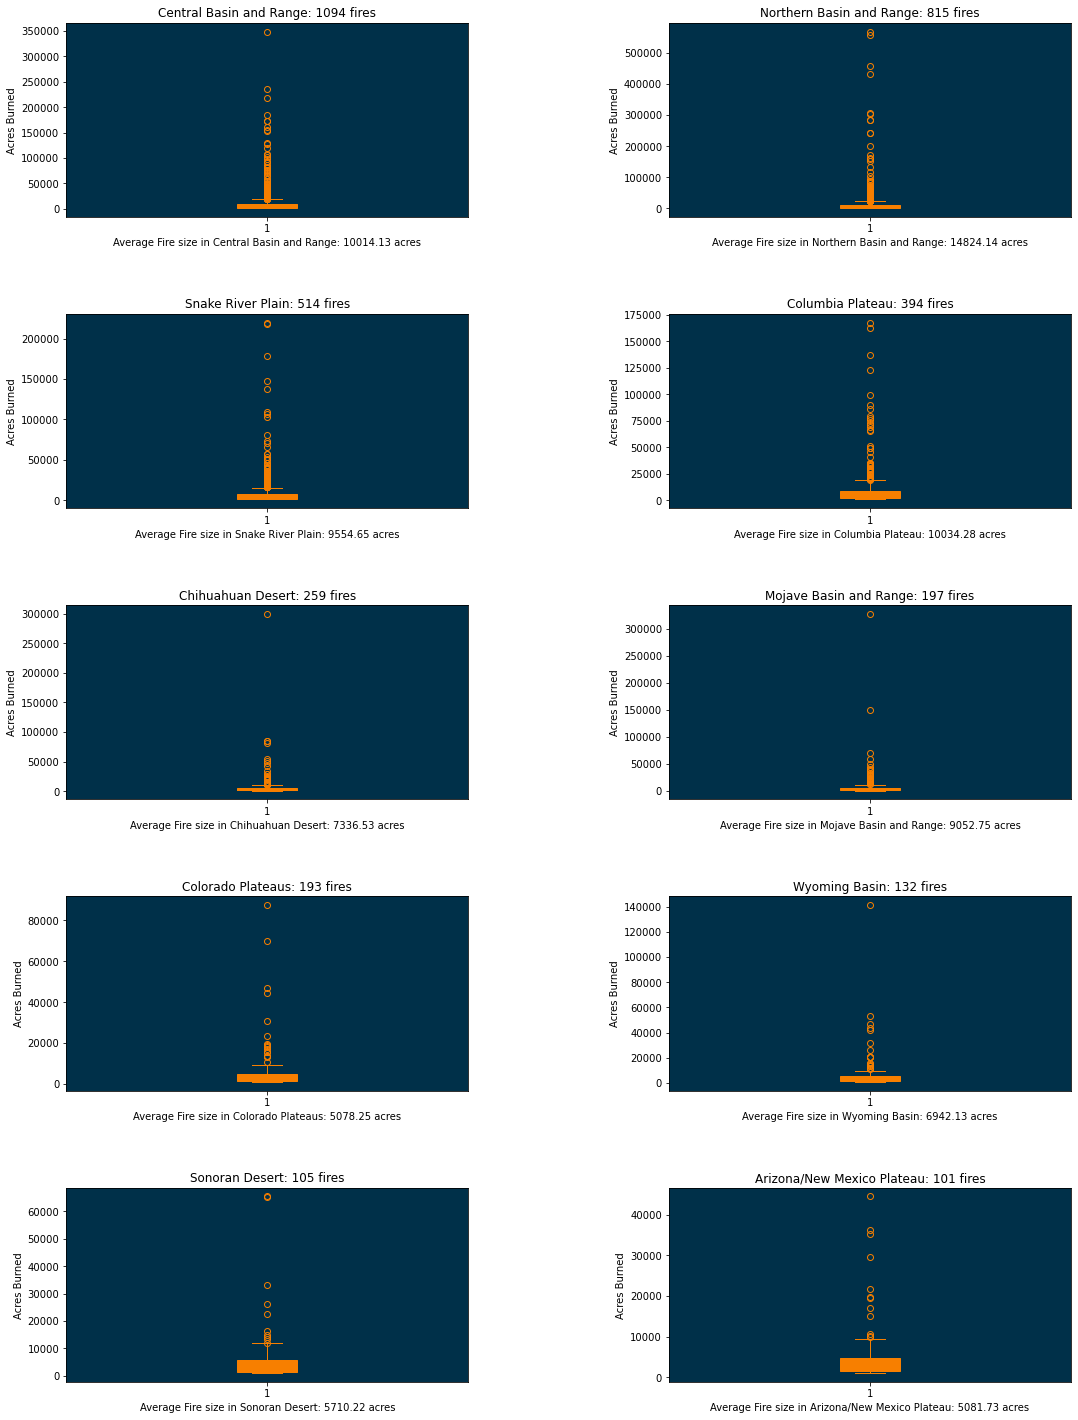

In [36]:
#North American Deserts
eco_10_size(top_5_ecos[2])

Level 3 ecosystems within NORTHWESTERN FORESTED MOUNTAINS


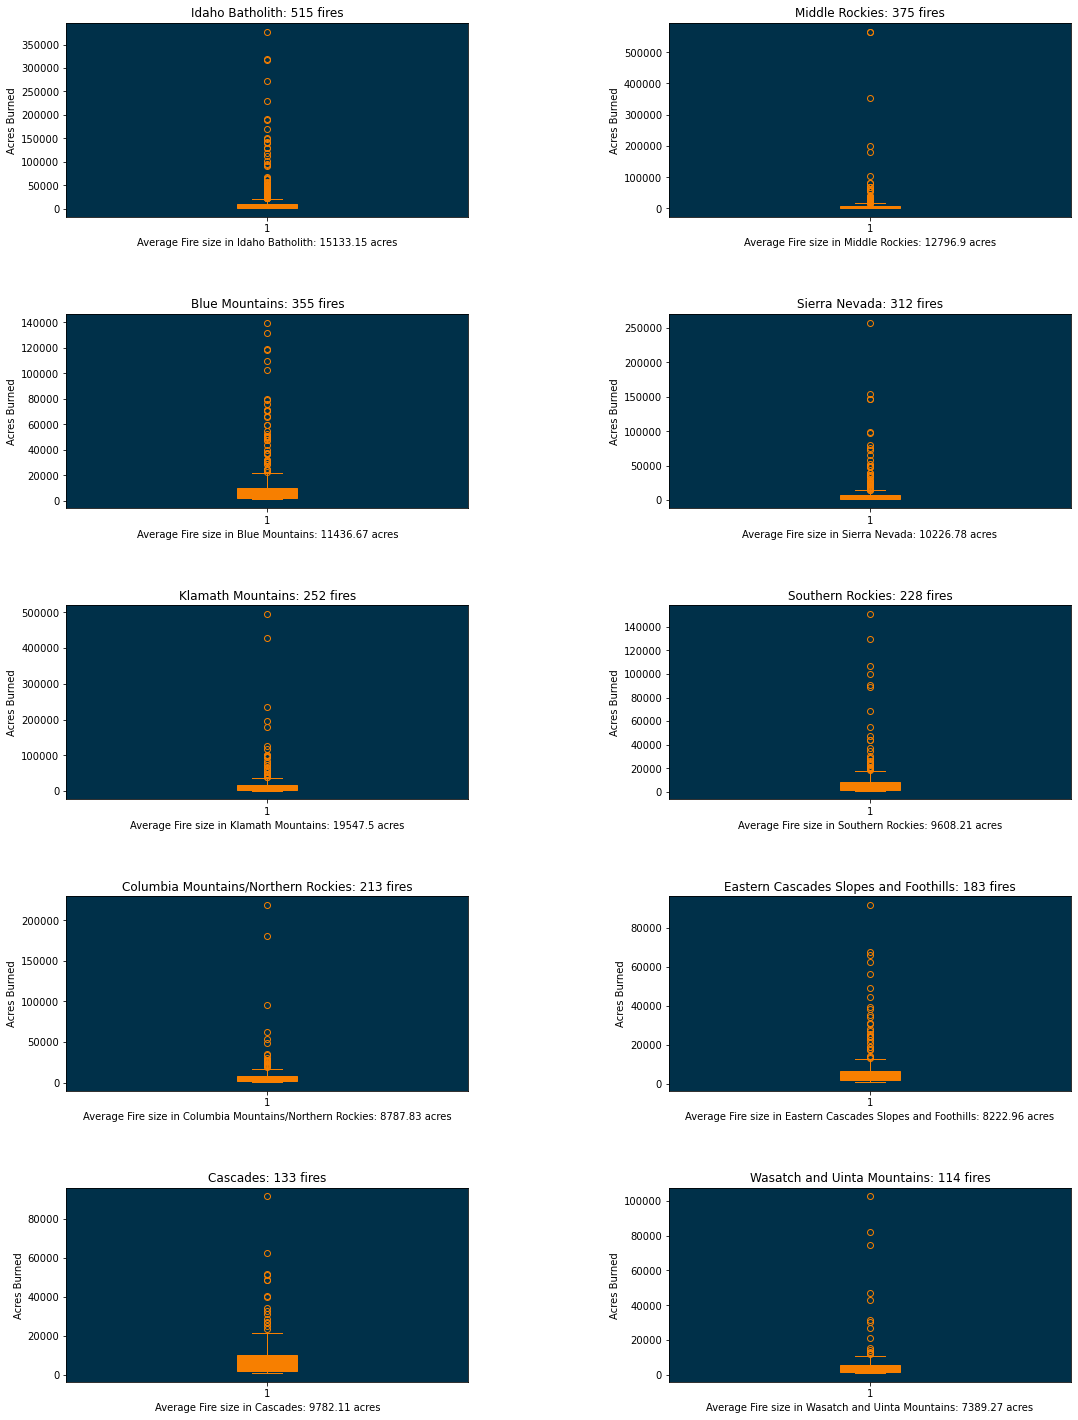

In [37]:
#North American Deserts
eco_10_size(top_5_ecos[3])

Level 3 ecosystems within MEDITERRANEAN CALIFORNIA


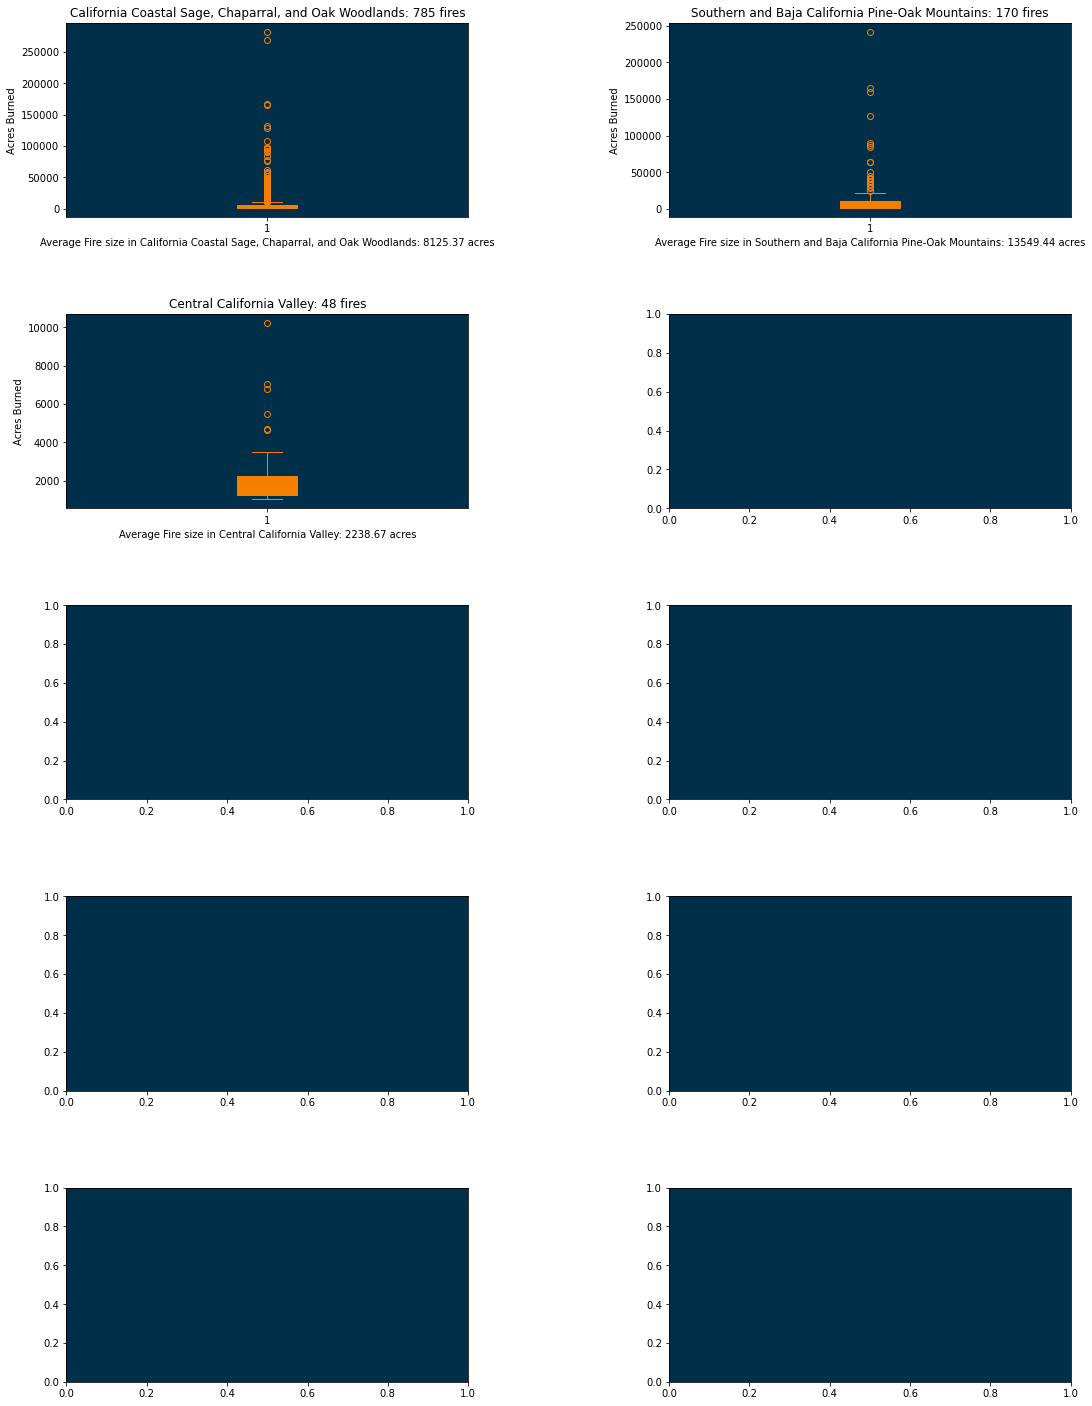

In [38]:
#Mediterranean California
eco_10_size(top_5_ecos[4])

In [39]:
top_10_states = list(mtbs['state'].value_counts().head(10).to_frame().reset_index()['index'])
top_state_df = mtbs[mtbs['state'].isin(top_10_states)]

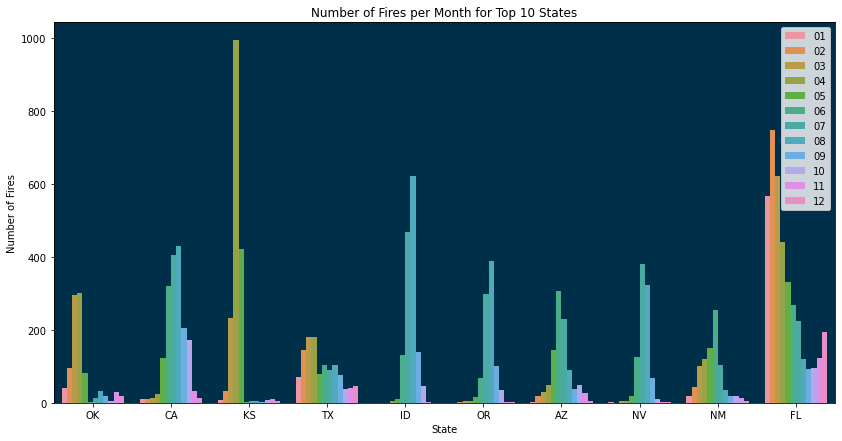

In [44]:
plt.figure(figsize=(14,7))
sns.countplot(top_state_df['state'], hue=top_state_df['month_ig'])
plt.xlabel('State')
plt.ylabel('Number of Fires')
plt.title('Number of Fires per Month for Top 10 States')
plt.legend(facecolor='white')
plt.savefig('month_count.png', bbox_inches='tight')
plt.show()

##### Deep Exploration Summary

1. Looking at the size of fires by type, prescribed fires burn a much smaller area compared to wildfires; 2,100 acres compared to 9,000 acres. You'll also notice between their two boxplots that the max wildfire burn area (~600K acres) is roughly five times that of the max area burned in a prescribed fire.
2. As far as states go, we found out earlier that the largest number of the fires have occured in Florida, which I found surprising because I always assumed all the fires occurred out west in states like California and Oregon. If we look at the top ten states with largest number of fires, we'll notice that though Florida has the highest number of fires, it does not have the largest fires. The average fire size in Florida is only 2,000 acres, while the average fire size in western states is four or five times that.
3. When initially looking through the data, I noticed that in addition to a large number of fires occuring in the summer months, there were quite a number of fires occuring in the spring months as well. Looking closer at the top 10 states, we can see that the fires that occur during the spring months happen in Florida and Kansas, while the fires that occur during the summer happen more in the western states.

### Climate Data Join

In [47]:
#Converting weather date column to date
level_1_weather['Date'] = pd.to_datetime(level_1_weather['Date'], format='%Y-%m-%d')

In [48]:
weather_cols = list(level_1_weather.columns[3:])
weather_cols

['max_temp_C_30',
 'max_temp_C_90',
 'max_temp_C_180',
 'max_temp_C_365',
 'min_temp_C_30',
 'min_temp_C_90',
 'min_temp_C_180',
 'min_temp_C_365',
 'precipitation_cm_30',
 'precipitation_cm_90',
 'precipitation_cm_180',
 'precipitation_cm_365',
 'wind_speed_ms_30',
 'wind_speed_ms_90',
 'wind_speed_ms_180',
 'wind_speed_ms_365']

## Explain weather columns

The weather columns listed in the cell above are columns I created in a separate Jupyter Notebook. They are as follows:
1. **max_temp_C_30** - Average maximum temperature (degrees Celsius) for the Level 1 Ecoregion in the 30 days prior to the start of the fire
2. **max_temp_C_90** - Average maximum temperature (degrees Celsius) for the Level 1 Ecoregion in the 90 days prior to the start of the fire
3. **max_temp_C_180** - Average maximum temperature (degrees Celsius) for the Level 1 Ecoregion in the 180 days prior to the start of the fire
4. **max_temp_C_365** - Average maximum temperature (degrees Celsius) for the Level 1 Ecoregion in the 365 days prior to the start of the fire
5. **min_temp_C_30** - Average miniumum temperature (degrees Celsius) for the Level 1 Ecoregion in the 30 days prior to the start of the fire
6. **min_temp_C_90** - Average miniumum temperature (degrees Celsius) for the Level 1 Ecoregion in the 90 days prior to the start of the fire
7. **min_temp_C_180** - Average miniumum temperature (degrees Celsius) for the Level 1 Ecoregion in the 180 days prior to the start of the fire
8. **min_temp_C_365** - Average miniumum temperature (degrees Celsius) for the Level 1 Ecoregion in the 365 days prior to the start of the fire
9. **precipitation_cm_30** - Total precipitation (in cm) for the Level 1 Ecoregion in the 30 days prior to the start of the fire
10. **precipitation_cm_90** - Total precipitation (in cm) for the Level 1 Ecoregion in the 90 days prior to the start of the fire
11. **precipitation_cm_180** - Total precipitation (in cm) for the Level 1 Ecoregion in the 180 days prior to the start of the fire
12. **precipitation_cm_365** - Total precipitation (in cm) for the Level 1 Ecoregion in the 365 days prior to the start of the fire
13. **wind_speed_ms_30** - Average daily windspeed (in m/s) for the Level 1 Ecoregion in the 30 days prior to the start of the fire
14. **wind_speed_ms_90** - Average daily windspeed (in m/s) for the Level 1 Ecoregion in the 90 days prior to the start of the fire
15. **wind_speed_ms_180** - Average daily windspeed (in m/s) for the Level 1 Ecoregion in the 180 days prior to the start of the fire
16. **wind_speed_ms_365** - Average daily windspeed (in m/s) for the Level 1 Ecoregion in the 365 days prior to the start of the fire

In [49]:
#Joining level 1 ecosystem weather with the mtbs dataset
mtbs_weather_1 = pd.merge(mtbs, level_1_weather, how='left', on=['NA_L1NAME', 'Date'])
mtbs_weather_1.dropna(inplace=True)

In [50]:
#Now to look for weather trends relating to size of fire
#Variables for trend plotting
three_month_weather = ['max_temp_C_90', 'min_temp_C_90', 'precipitation_cm_90', 'wind_speed_ms_90']

#Trend plotting
def trend_plots(cols, df):
    """Takes the columns containing weather data and plotting them against the acres burned in a scatter plot.
    
    Parameters:
    cols = list of weather columns
    df = dataframe"""
    
    fig, axs = plt.subplots(2,2, figsize=(14, 8))
    fig.subplots_adjust(hspace = .5, wspace=.5)

    axs = axs.ravel()

    for i in range(len(cols)):
        axs[i].scatter(x=cols[i], y='Acres',data=df, color=color1)
        axs[i].set_title('{} vs. Fire Size (Acres)'.format(cols[i]))
        axs[i].set_xlabel('{}'.format(cols[i]))
        axs[i].set_ylabel('Acres Burned')
    plt.show()

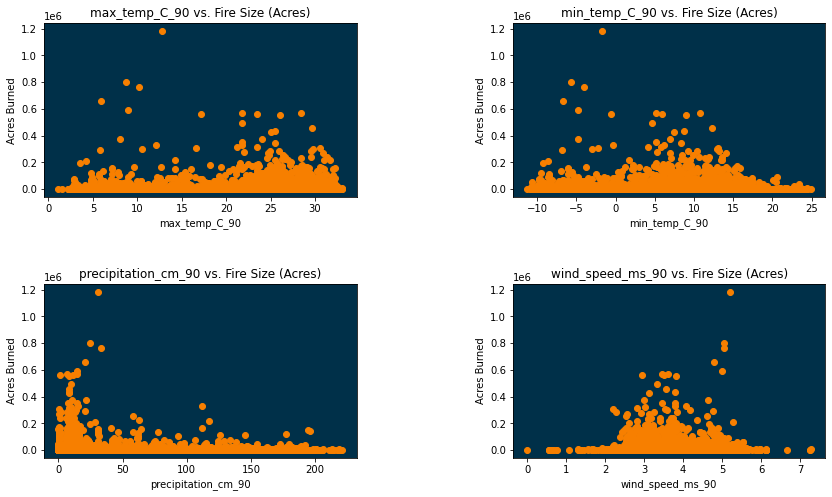

In [51]:
#Trend plotting unfiltered dataset
trend_plots(three_month_weather, mtbs_weather_1)

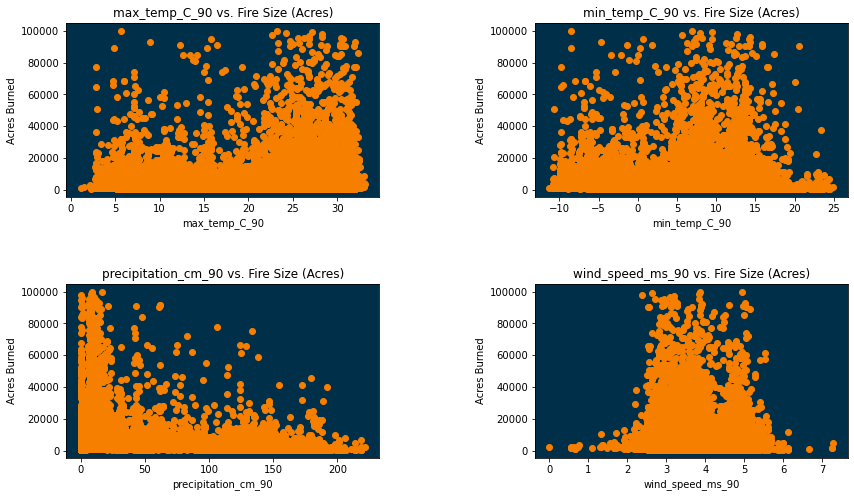

In [52]:
#Trend plotting for fires under 2,000 acres
under_100k = mtbs_weather_1[mtbs_weather_1['Acres'] < 100000]
trend_plots(three_month_weather, under_100k)

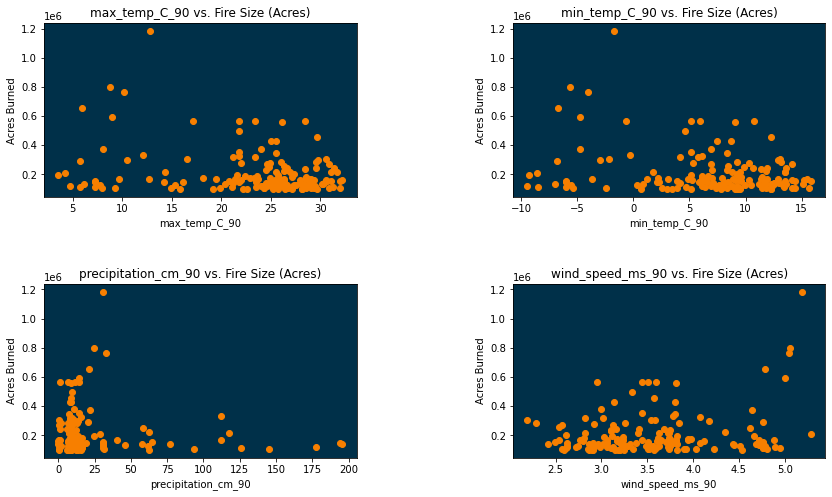

In [53]:
#Trend plotting for fires over 2,000 acres
over_100k = mtbs_weather_1[mtbs_weather_1['Acres'] > 100000]
trend_plots(three_month_weather, over_100k)

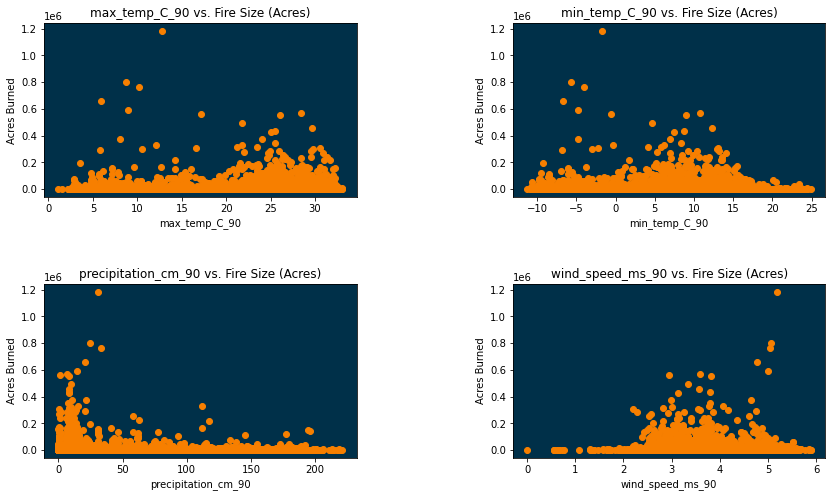

In [54]:
#Trend plotting for fires that occurred after 1990
after_1990 = mtbs_weather_1[mtbs_weather_1['Date'] >= '1990-01-01']
trend_plots(three_month_weather, after_1990)

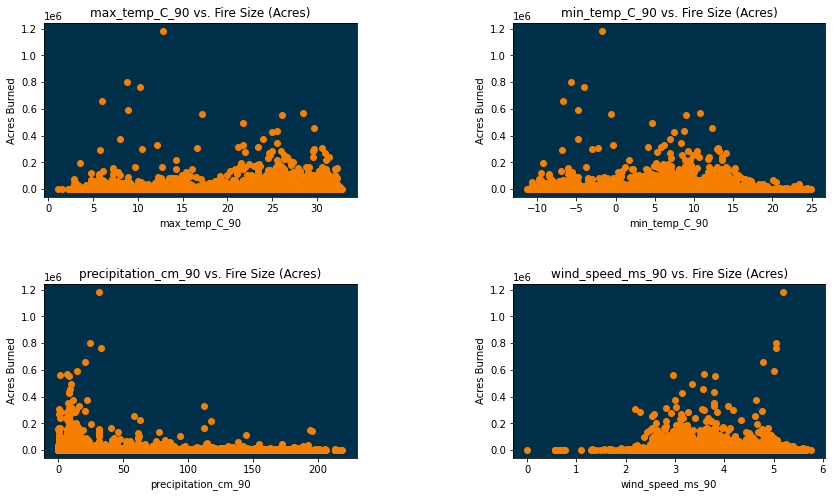

In [55]:
#Trend plotting for fires that occurred after 2000
after_2000 = mtbs_weather_1[mtbs_weather_1['Date'] >= '2000-01-01']
trend_plots(three_month_weather, after_2000)

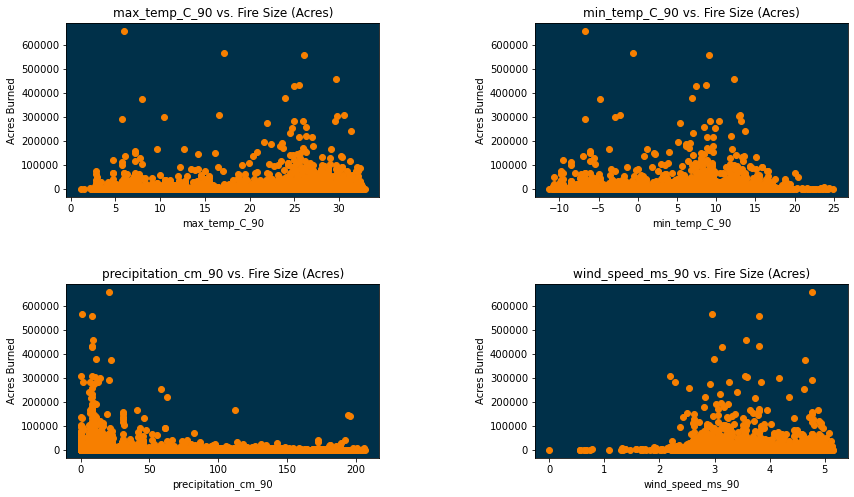

In [56]:
#Trend plotting for fires that occurred after 2010
after_2010 = mtbs_weather_1[mtbs_weather_1['Date'] >= '2010-01-01']
trend_plots(three_month_weather, after_2010)

#### Trend plots for top 5 states

In [57]:
top_5_states = list(mtbs['state'].value_counts().head(5).to_frame().reset_index()['index'])
top_5_states

['FL', 'CA', 'KS', 'ID', 'TX']

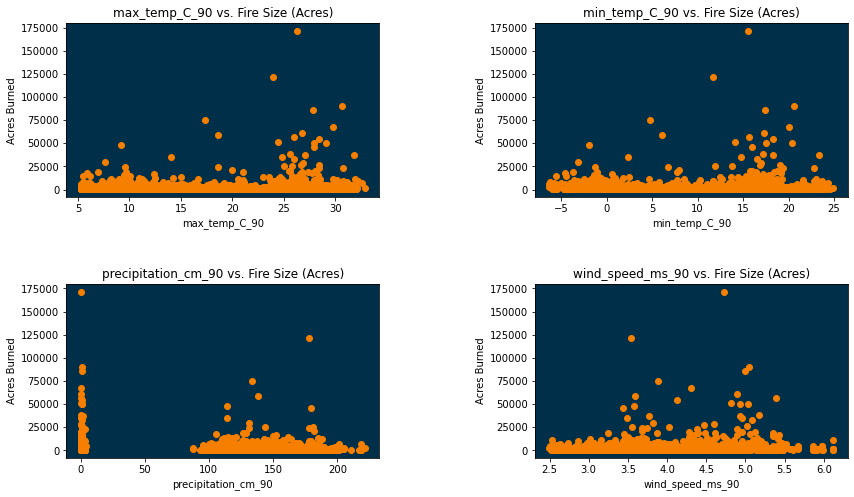

In [58]:
#Florida
fl = mtbs_weather_1[mtbs_weather_1['state'] == 'FL']
trend_plots(three_month_weather, fl)

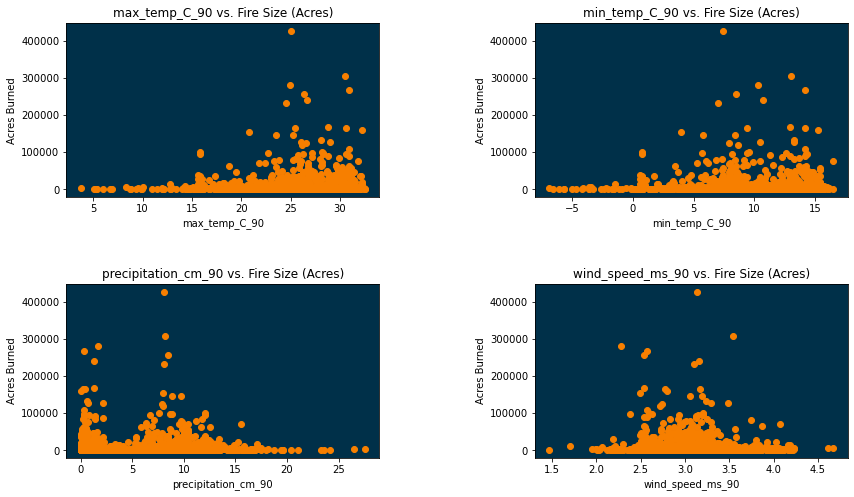

In [59]:
#California
ca = mtbs_weather_1[mtbs_weather_1['state'] == 'CA']
trend_plots(three_month_weather, ca)

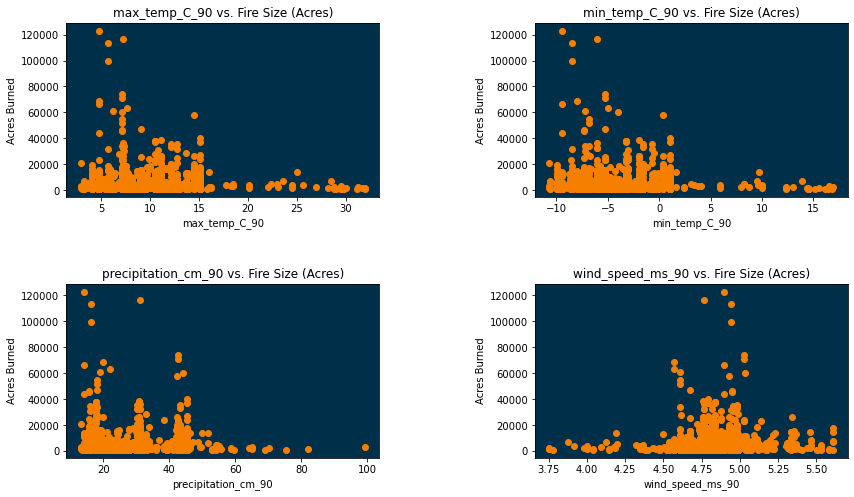

In [60]:
#Kansas
ks = mtbs_weather_1[(mtbs_weather_1['state'] == 'KS') & (mtbs_weather_1['Acres'] < 200000)]
trend_plots(three_month_weather, ks)

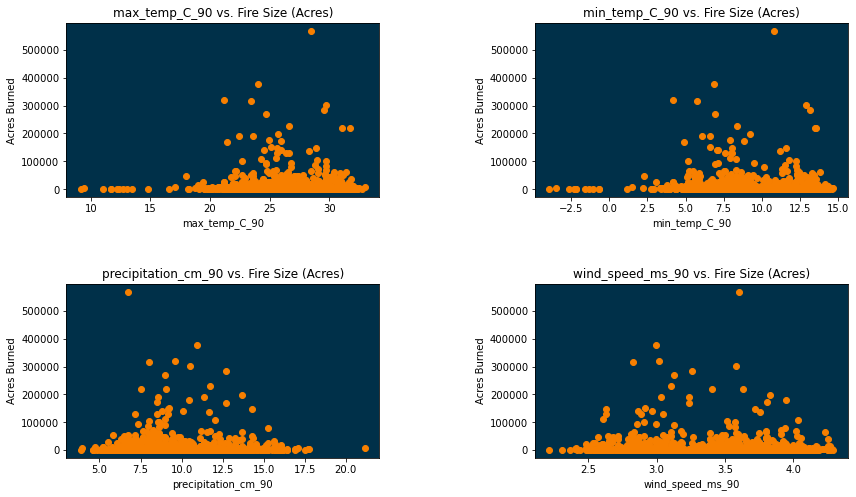

In [61]:
#Idaho
id_ = mtbs_weather_1[mtbs_weather_1['state'] == 'ID']
trend_plots(three_month_weather, id_)

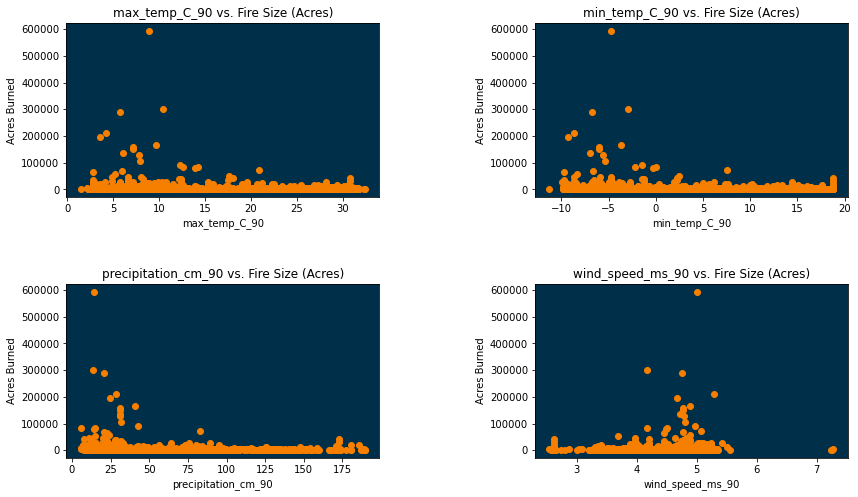

In [62]:
#Texas
tx = mtbs_weather_1[mtbs_weather_1['state'] == 'TX']
trend_plots(three_month_weather, tx)

#### Trend plots for top 5 ecoregions

In [63]:
top_5_ecos = list(mtbs['NA_L1NAME'].value_counts().head(5).to_frame().reset_index()['index'])
top_5_ecos

['EASTERN TEMPERATE FORESTS',
 'GREAT PLAINS',
 'NORTH AMERICAN DESERTS',
 'NORTHWESTERN FORESTED MOUNTAINS',
 'MEDITERRANEAN CALIFORNIA']

Weather trend plots for: EASTERN TEMPERATE FORESTS


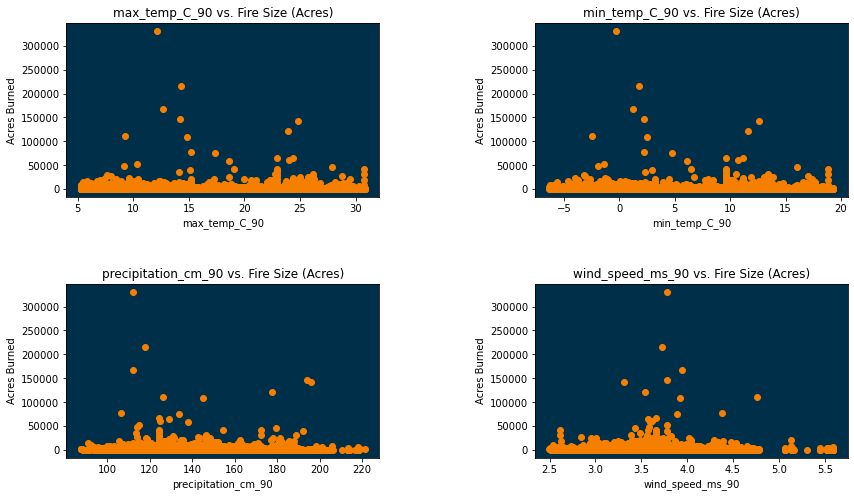

Weather trend plots for: GREAT PLAINS


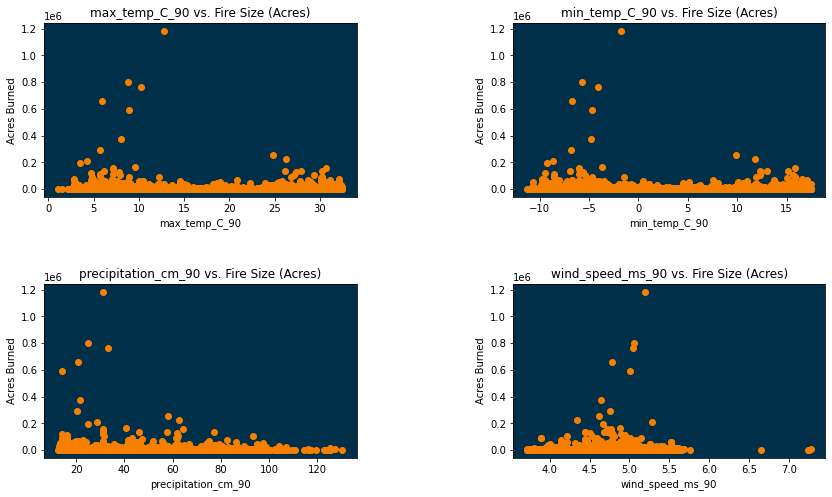

Weather trend plots for: NORTH AMERICAN DESERTS


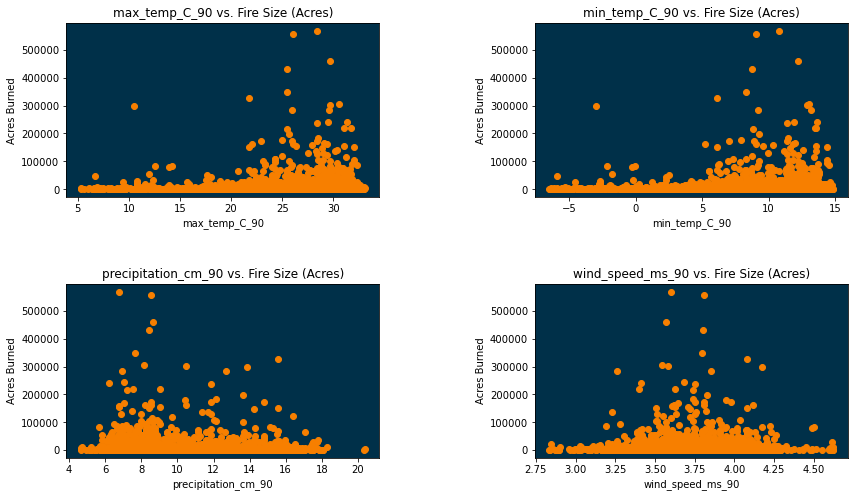

Weather trend plots for: NORTHWESTERN FORESTED MOUNTAINS


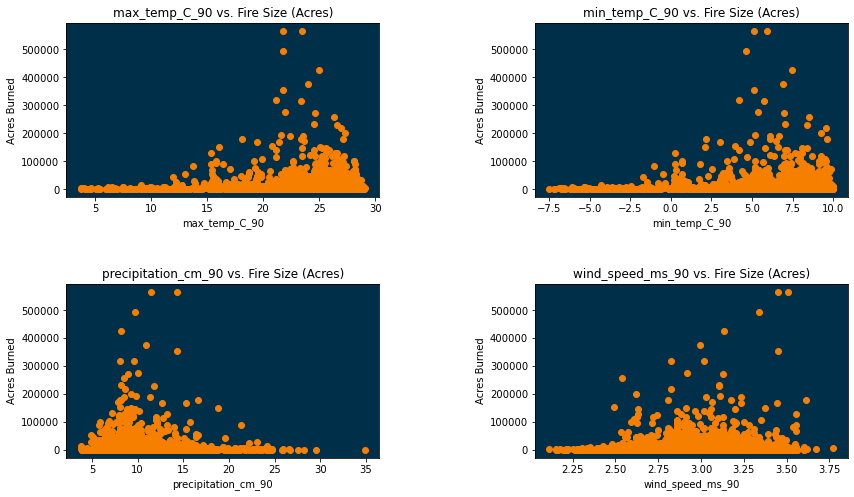

Weather trend plots for: MEDITERRANEAN CALIFORNIA


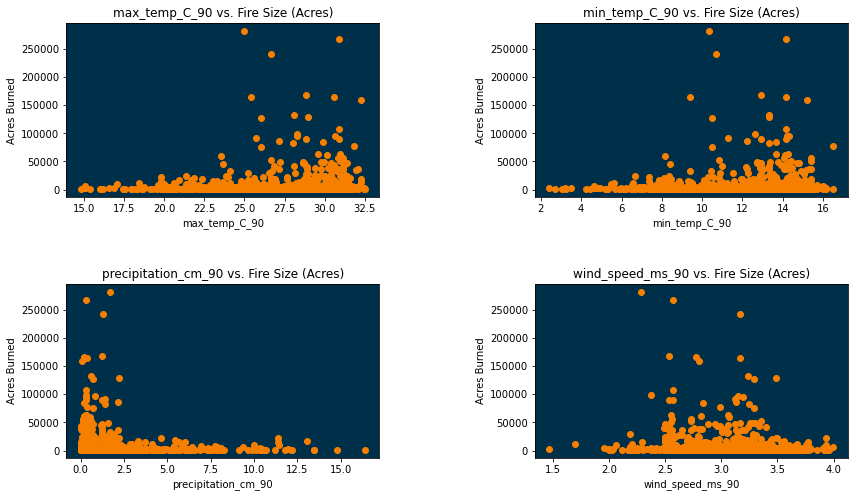

In [64]:
#Looking through top 5 ecoregions
for reg in top_5_ecos:
    df = mtbs_weather_1[mtbs_weather_1['NA_L1NAME'] == reg]
    print('Weather trend plots for: {}'.format(reg))
    trend_plots(three_month_weather, df)

##### Climate Exploration Summary

Though the trends may not be as clear as I would have expected, there are still a few conclusions we can draw from what we see above. First, in some ecoregions, especially where there are on average larger fires, the acres burned tends to increase as the average minimum and maximum 3-month temperatures increase. Second, though rainfall doesn't have as much an affect on the size of the fire, we can see that the more rainfall over a three-month period, the less likely a chance of fire.

## Model Generation

I want to be able to create a mulitple linear regression model that takes weather and location data to predict the size of a fire. Using the OLS linear regression from the statsmodel package, I'm going to see what kind of models my data generates.

### Model Round 1

#### Preparing Data for Modeling - Round 1 - Different Date Ranges

In [66]:
dfs = [mtbs_weather_1, after_1990, after_2000, after_2010]

In [67]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L1NAME', 'state', 'month_ig', 'max_temp_C_90',
           'min_temp_C_90', 'precipitation_cm_90', 'wind_speed_ms_90']
target = ['Acres']

In [68]:
preds_full = mtbs_weather_1[col_keep]
preds_90 = after_1990[col_keep]
preds_00 = after_2000[col_keep]
preds_10 = after_2010[col_keep]

target_full = mtbs_weather_1[target]
target_90 = after_1990[target]
target_00 = after_2000[target]
target_10 = after_2010[target]

In [69]:
#Dummy Variables
predictors_full = pd.get_dummies(preds_full, drop_first=True)
predictors_90 = pd.get_dummies(preds_90, drop_first=True)
predictors_00 = pd.get_dummies(preds_00, drop_first=True)
predictors_10 = pd.get_dummies(preds_10, drop_first=True)

In [70]:
#Checking for multicolinearity
corr_df = pd.DataFrame(predictors_90.corr()[abs(predictors_90.corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value
223,min_temp_C_90,max_temp_C_90,0.961013
295,max_temp_C_90,min_temp_C_90,0.961013


In [71]:
#Seeing which column is more correlated with the target
colin_check = pd.concat([predictors_full[['min_temp_C_90', 'max_temp_C_90']],
                         target_full], axis=1)
colin_check.corr()

,min_temp_C_90,max_temp_C_90,Acres
min_temp_C_90,1.000000,0.958764,0.050697
max_temp_C_90,0.958764,1.000000,0.088610
Acres,0.050697,0.088610,1.000000


In [72]:
#Dropping 'min_temp'
predictors_full.drop(columns='min_temp_C_90', inplace=True)
predictors_90.drop(columns='min_temp_C_90', inplace=True)
predictors_00.drop(columns='min_temp_C_90', inplace=True)
predictors_10.drop(columns='min_temp_C_90', inplace=True)

In [73]:
targets = [target_full, target_90, target_00, target_10]
predictors = [predictors_full, predictors_90, predictors_00, predictors_10]
labels = ['Full Dataset', 'After 1990', 'After 2000', 'After 2010']

#### Modeling

In [74]:
#OLS Statsmodel
for i in range(len(targets)):
    X_train, X_test, y_train, y_test = train_test_split(predictors[i], targets[i], test_size=0.2)
    mod_1 = sm.OLS(y_train, sm.add_constant(X_train.astype(float))).fit()
    print(labels[i])
    print(mod_1.summary())
    print('\n')

Full Dataset
                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     8.469
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.46e-83
Time:                        21:45:47   Log-Likelihood:            -1.9233e+05
No. Observations:               16711   AIC:                         3.848e+05
Df Residuals:                   16639   BIC:                         3.854e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

After 2000
                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.825
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.52e-62
Time:                        21:45:47   Log-Likelihood:            -1.4230e+05
No. Observations:               12270   AIC:                         2.847e+05
Df Residuals:                   12197   BIC:                         2.853e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Model Round 2

#### Preparing Data for Modeling - Round 2 - Different Sizes

In [75]:
mtbs_weather_1['Acres'].describe()

count    2.088900e+04
mean     6.557263e+03
std      2.414007e+04
min      5.000000e+02
25%      1.223000e+03
50%      2.025000e+03
75%      4.377000e+03
max      1.183539e+06
Name: Acres, dtype: float64

In [76]:
under_5k = mtbs_weather_1[mtbs_weather_1['Acres'] <= 5000]
over_5k = mtbs_weather_1[mtbs_weather_1['Acres'] > 5000]

In [77]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L1NAME', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90', 'wind_speed_ms_90']
target = ['Acres']

In [78]:
preds_over = over_5k[col_keep]
preds_under = under_5k[col_keep]

target_over = over_5k[target]
target_under = under_5k[target]

In [79]:
#Dummy Variables
predictors_over = pd.get_dummies(preds_over, drop_first=True)
predictors_under = pd.get_dummies(preds_under, drop_first=True)

In [80]:
#Checking for multicolinearity
corr_df = pd.DataFrame(predictors_under.corr()[abs(predictors_under.corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value


In [81]:
#Seeing which column is more correlated with the target
colin_check = pd.concat([predictors_over[['max_temp_C_90']],
                         target_over], axis=1)
colin_check.corr()

,max_temp_C_90,Acres
max_temp_C_90,1.000000,0.031719
Acres,0.031719,1.000000


In [82]:
targets = [target_over, target_under]
predictors = [predictors_over, predictors_under]
labels = ['Over 5K', 'Under 5K']

#### Modeling

In [83]:
for i in range(len(targets)):
    X_train, X_test, y_train, y_test = train_test_split(predictors[i], targets[i], test_size=0.2)
    mod_1 = sm.OLS(y_train, sm.add_constant(X_train.astype(float))).fit()
    print(labels[i])
    print(mod_1.summary())
    print('\n')

Over 5K
                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.521
Date:                Mon, 14 Dec 2020   Prob (F-statistic):            0.00587
Time:                        21:45:55   Log-Likelihood:                -44752.
No. Observations:                3674   AIC:                         8.963e+04
Df Residuals:                    3612   BIC:                         9.001e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     29.25
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:45:55   Log-Likelihood:            -1.0863e+05
No. Observations:               13036   AIC:                         2.174e+05
Df Residuals:                   12964   BIC:                         2.179e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

### Model Round 3

#### Preparing Data for Modeling - Round 3 - Continuing with Different Sizes

In [84]:
mtbs_weather_1['Acres'].describe()

count    2.088900e+04
mean     6.557263e+03
std      2.414007e+04
min      5.000000e+02
25%      1.223000e+03
50%      2.025000e+03
75%      4.377000e+03
max      1.183539e+06
Name: Acres, dtype: float64

In [85]:
under_2k = mtbs_weather_1[mtbs_weather_1['Acres'] <= 2000]
under_5k = mtbs_weather_1[(mtbs_weather_1['Acres'] > 2000) & (mtbs_weather_1['Acres'] <= 5000)]
under_20k = mtbs_weather_1[(mtbs_weather_1['Acres'] > 5000) & (mtbs_weather_1['Acres'] <= 20000)]
over_20k = mtbs_weather_1[mtbs_weather_1['Acres'] > 20000]

In [86]:
col_keep = ['Fire_Type', 'Low_T', 'Mod_T', 'High_T', 'NA_L1NAME', 'state', 'month_ig', 'max_temp_C_90',
           'precipitation_cm_90', 'wind_speed_ms_90']
target = ['Acres']

In [87]:
preds_2k = under_2k[col_keep]
preds_5k = under_5k[col_keep]
preds_20k = under_20k[col_keep]
preds_max = over_20k[col_keep]

target_2k = under_2k[target]
target_5k = under_5k[target]
target_20k = under_20k[target]
target_max = over_20k[target]

In [88]:
#Dummy Variables
predictors_2k = pd.get_dummies(preds_2k, drop_first=True)
predictors_5k = pd.get_dummies(preds_5k, drop_first=True)
predictors_20k = pd.get_dummies(preds_20k, drop_first=True)
predictors_max = pd.get_dummies(preds_max, drop_first=True)

In [89]:
#Checking for multicolinearity
corr_df = pd.DataFrame(predictors_2k.corr()[abs(predictors_2k.corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value


In [90]:
#Seeing which column is more correlated with the target
colin_check = pd.concat([predictors_2k[['max_temp_C_90']],
                         target_2k], axis=1)
colin_check.corr()

,max_temp_C_90,Acres
max_temp_C_90,1.0000,0.1544
Acres,0.1544,1.0000


In [91]:
targets = [target_2k, target_5k, target_20k, target_max]
predictors = [predictors_2k, predictors_5k, predictors_20k, predictors_max]
labels = ['Under 2K', 'Between 2K and 5K', 'Between 5K and 20K', 'Over 20K']

#### Modeling

In [92]:
for i in range(len(targets)):
    X_train, X_test, y_train, y_test = train_test_split(predictors[i], targets[i], test_size=0.2)
    mod_1 = sm.OLS(y_train, sm.add_constant(X_train.astype(float))).fit()
    print(labels[i])
    print(mod_1.summary())
    print('\n')

Under 2K
                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     35.09
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:46:03   Log-Likelihood:                -60266.
No. Observations:                8272   AIC:                         1.207e+05
Df Residuals:                    8199   BIC:                         1.212e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.204
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.161
Time:                        21:46:03   Log-Likelihood:                -11906.
No. Observations:                 944   AIC:                         2.391e+04
Df Residuals:                     893   BIC:                         2.416e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

As we can see here, the models don't look too great. In a separate notebook, I'm going to zoom in on the weather data, and try to model across different timelines before I think about normal distribution and scaling variables.

In [93]:
mtbs.to_csv('MTBS_clean.csv')